In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [2]:
def simulate_agent(waypoints, num_waypoints, speed_init, time_delta=0.1,
                   kp_speed=1, kp_steering=1, max_accel=4, max_steering=1, max_speed=100):
    """
    Simulates low-level control actions for an agent following waypoints.
    
    Parameters:
        env: object containing entities
        agent_idx: index of the agent in env.entities
        waypoints: list of [x, y] targets
        num_waypoints: number of waypoints to simulate
        time_delta: timestep for simulation
        kp_speed: proportional gain for speed control
        kp_steering: proportional gain for steering control
        max_accel: maximum allowed acceleration
        max_steering: maximum allowed steering angle
        max_speed: maximum allowed speed
    """
    # Initial state
    sim_x = 0
    sim_y = 0
    sim_heading = 0
    sim_vx = speed_init
    sim_vy = 0
    agent_length = 3.5

    low_level_actions = [[0.0, 0.0] for _ in range(num_waypoints)]
    dreamed_waypoints = [[0.0, 0.0] for _ in range(num_waypoints)]


    def clip_value(val, lo, hi):
        return max(lo, min(val, hi))

    def relative_distance_2d(x1, y1, x2, y2):
        return math.hypot(x2 - x1, y2 - y1)

    def clip_speed(speed):
        return min(speed, max_speed)

    for i in range(num_waypoints):
        # Current simulated state
        sim_speed = math.sqrt(sim_vx ** 2 + sim_vy ** 2)

        # Target waypoint
        
        target_x, target_y = waypoints[i+7]

        # Compute target speed
        dist_to_target = relative_distance_2d(sim_x, sim_y, target_x, target_y)
        target_speed = dist_to_target / time_delta

        # Compute desired acceleration
        speed_error = target_speed - sim_speed
        desired_accel = (kp_speed * speed_error) / time_delta
        # desired_accel = 2.0

        # Compute desired steering
        dx = target_x - sim_x
        dy = target_y - sim_y
        desired_yaw = math.atan2(dy, dx)

        # Yaw error wrapped to [-pi, pi]
        yaw_error = desired_yaw - sim_heading
        yaw_error = math.atan2(math.sin(yaw_error), math.cos(yaw_error))

        # Proportional steering
        desired_steering = kp_steering * yaw_error

        # Speed-dependent steering reduction
        # speed_factor = max(0.1, 1.0 - sim_speed / 50.0)
        # desired_steering *= speed_factor

        # Clip to vehicle limits
        clipped_accel = clip_value(desired_accel, -max_accel, max_accel)
        clipped_steering = clip_value(desired_steering, -max_steering, max_steering)

        # Store the action
        low_level_actions[i][0] = clipped_accel
        low_level_actions[i][1] = clipped_steering

        # --- Simulate one step forward ---
        next_sim_speed = sim_speed + clipped_accel * time_delta
        if next_sim_speed < 0:
            next_sim_speed = 0
        next_sim_speed = clip_speed(next_sim_speed)

        beta = math.tanh(0.5 * math.tan(clipped_steering))
        yaw_rate = (next_sim_speed * math.cos(beta) * math.tan(clipped_steering)) / agent_length

        sim_vx = next_sim_speed * math.cos(sim_heading + beta)
        sim_vy = next_sim_speed * math.sin(sim_heading + beta)

        sim_x += sim_vx * time_delta
        sim_y += sim_vy * time_delta
        dreamed_waypoints[i][0] = sim_x
        dreamed_waypoints[i][1] = sim_y
        sim_heading += yaw_rate * time_delta

    return low_level_actions, dreamed_waypoints

In [14]:
def simulate_agent_lookahead(waypoints, num_waypoints, speed_init, time_delta=0.1,
                   kp_speed=1, kp_steering=1, max_accel=4, max_steering=1, max_speed=100):
    """
    Simulates low-level control actions for an agent following waypoints.
    
    Parameters:
        env: object containing entities
        agent_idx: index of the agent in env.entities
        waypoints: list of [x, y] targets
        num_waypoints: number of waypoints to simulate
        time_delta: timestep for simulation
        kp_speed: proportional gain for speed control
        kp_steering: proportional gain for steering control
        max_accel: maximum allowed acceleration
        max_steering: maximum allowed steering angle
        max_speed: maximum allowed speed
    """
    # Initial state
    sim_x = 0
    sim_y = 0
    sim_heading = 0
    sim_vx = speed_init
    sim_vy = 0
    agent_length = 3.5

    low_level_actions = [[0.0, 0.0] for _ in range(num_waypoints)]
    dreamed_waypoints = [[0.0, 0.0] for _ in range(num_waypoints)]


    def clip_value(val, lo, hi):
        return max(lo, min(val, hi))

    def relative_distance_2d(x1, y1, x2, y2):
        return math.hypot(x2 - x1, y2 - y1)

    def clip_speed(speed):
        return min(speed, max_speed)

    for i in range(num_waypoints):
        # Current simulated state
        sim_speed = math.sqrt(sim_vx ** 2 + sim_vy ** 2)

        # Target waypoint
        target_idx = i + 0
        if target_idx >= num_waypoints:
            target_idx = num_waypoints - 1

        inter = target_idx - i + 1
        target_x = waypoints[target_idx][0]
        target_y = waypoints[target_idx][1]

        # Compute target speed
        dist_to_target = relative_distance_2d(sim_x, sim_y, target_x, target_y)
        target_speed = dist_to_target / (time_delta * inter)

        # Compute desired acceleration
        speed_error = target_speed - sim_speed
        desired_accel = (kp_speed * speed_error) / time_delta
        # desired_accel = 2.0

        # Compute desired steering
        dx = target_x - sim_x
        dy = target_y - sim_y
        desired_yaw = math.atan2(dy, dx)

        # Yaw error wrapped to [-pi, pi]
        yaw_error = desired_yaw - sim_heading
        yaw_error = math.atan2(math.sin(yaw_error), math.cos(yaw_error))

        # Proportional steering
        desired_steering = kp_steering * yaw_error

        # Speed-dependent steering reduction
        # speed_factor = max(0.1, 1.0 - sim_speed / 50.0)
        # desired_steering *= speed_factor

        # Clip to vehicle limits
        clipped_accel = clip_value(desired_accel, -max_accel, max_accel)
        clipped_steering = clip_value(desired_steering, -max_steering, max_steering)

        # Store the action
        low_level_actions[i][0] = clipped_accel
        low_level_actions[i][1] = clipped_steering

        # --- Simulate one step forward ---
        next_sim_speed = sim_speed + clipped_accel * time_delta
        if next_sim_speed < 0:
            next_sim_speed = 0
        next_sim_speed = clip_speed(next_sim_speed)

        beta = math.tanh(0.5 * math.tan(clipped_steering))
        yaw_rate = (next_sim_speed * math.cos(beta) * math.tan(clipped_steering)) / agent_length

        sim_vx = next_sim_speed * math.cos(sim_heading + beta)
        sim_vy = next_sim_speed * math.sin(sim_heading + beta)

        sim_x += sim_vx * time_delta
        sim_y += sim_vy * time_delta
        dreamed_waypoints[i][0] = sim_x
        dreamed_waypoints[i][1] = sim_y
        sim_heading += yaw_rate * time_delta

    return low_level_actions, dreamed_waypoints

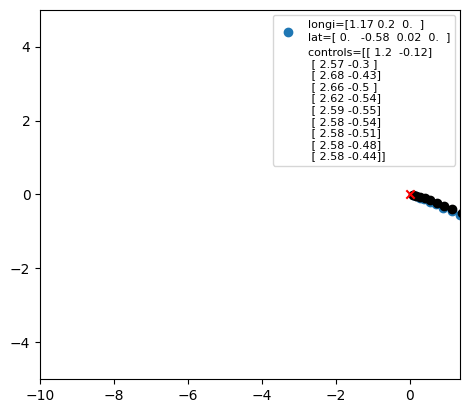

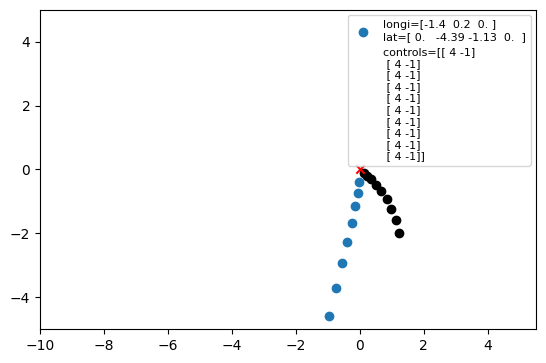

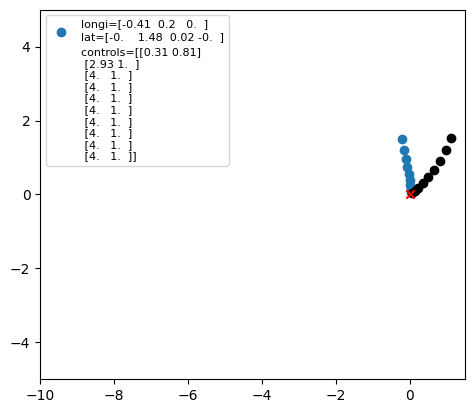

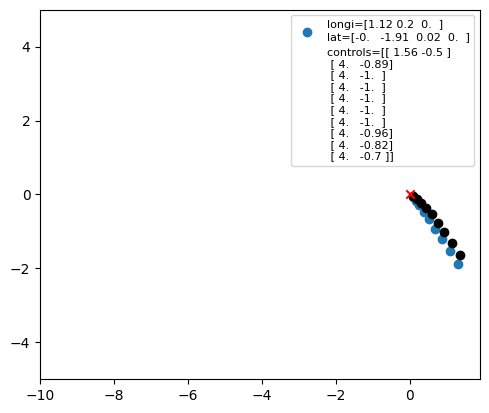

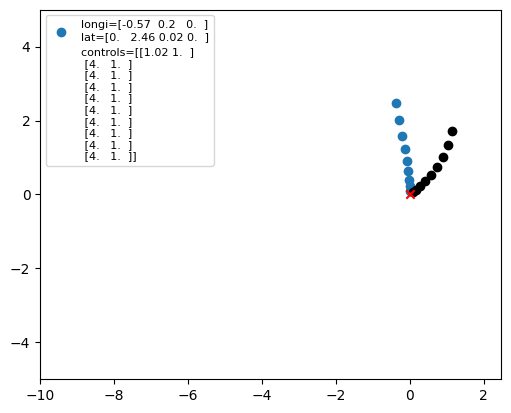

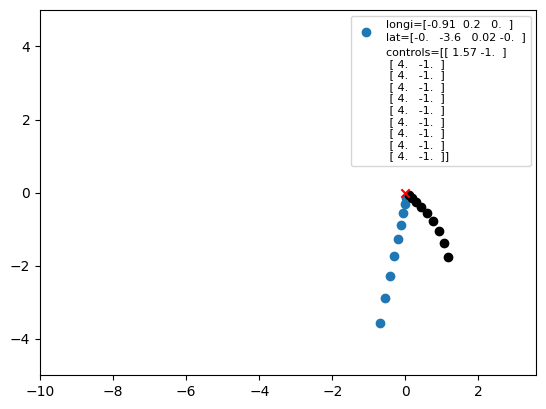

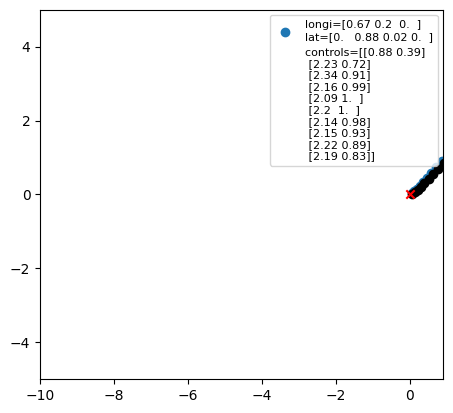

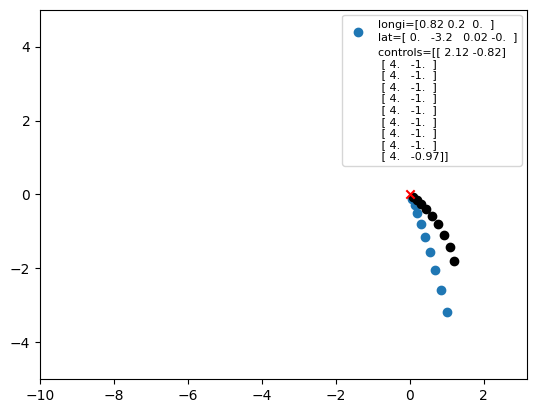

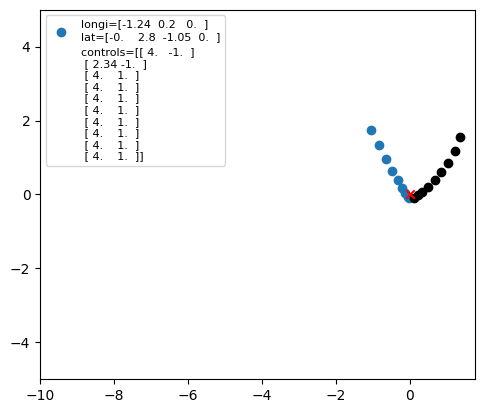

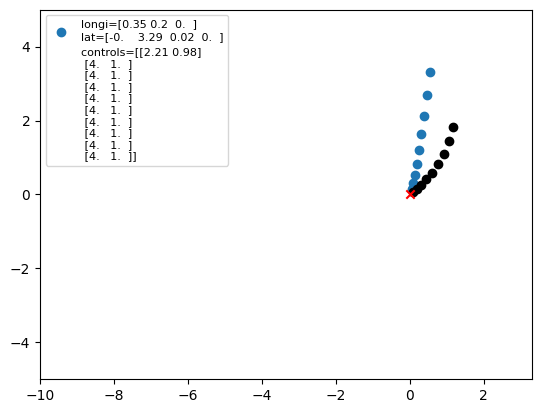

In [17]:
num_waypoints = 10
t_values = np.linspace(0, 1, num_waypoints + 1)
veh_speed = 0.2
USE_LOOKAHEAD = True
for _ in range(10):
    coeffs_longi = [random.uniform(-1, 1) for _ in range(3)]
    coeffs_longi[0] *= 1.5 # c2
    coeffs_longi[1] = veh_speed# c1
    coeffs_longi[2] = 0 # c0

    coeffs_lat = [random.uniform(-1, 1) for _ in range(4)]
    coeffs_lat[0] *= 0
    coeffs_lat[1] *= 5 # c2 10
    coeffs_lat[2] *= 5 # c1 3
    coeffs_lat[3] *= 0 # c0
    coeffs_lat[2] = min(coeffs_lat[2], 0.1 * veh_speed) # min(1, coeffs_longi[1])  # <-- note: this line ties lateral slope to longitudinal

    # Evaluate polynomials
    longi_traj = np.polyval(coeffs_longi, t_values)
    lateral_traj = np.polyval(coeffs_lat, t_values)

    # Stack waypoints
    local_waypoints = np.stack([longi_traj, lateral_traj], axis=-1)

    local_waypoints = local_waypoints[1:]
    if USE_LOOKAHEAD:
        control_actions, dreamed_waypoints = simulate_agent_lookahead(local_waypoints, num_waypoints=len(t_values)-1, speed_init=veh_speed)
    else:
        control_actions, dreamed_waypoints = simulate_agent(local_waypoints, num_waypoints=len(t_values)-1, speed_init=veh_speed)
    dreamed_waypoints = np.array(dreamed_waypoints)
    control_actions = np.array(control_actions)
    control_actions = control_actions

    # Plot
    plt.scatter(local_waypoints[1:, 0], local_waypoints[1:, 1],
                label=f"longi={np.round(coeffs_longi,2)}\nlat={np.round(coeffs_lat,2)}")

    plt.scatter(dreamed_waypoints[1:, 0], dreamed_waypoints[1:, 1], c='black', marker='o')
    plt.plot([], [], ' ', label=f"controls={np.round(control_actions,2)}")
    # --- Keep (0,0) at the center ---
    max_range = np.max(np.abs(local_waypoints))
    plt.xlim(-10, max_range)
    plt.ylim(-5, 5)
    plt.gca().set_aspect('equal', adjustable='box')

    plt.scatter(0, 0, c='red', marker='x')
    plt.legend(fontsize=8, loc="best")
    plt.show()


In [ ]:
local_waypoints

In [ ]:
num_waypoints = 10
t_values = np.linspace(0, 1, num_waypoints + 1)
t_values

In [ ]:
local_waypoints

In [ ]:
dreamed_waypoints

In [ ]:
control_actions

In [ ]:
t_values